In [51]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [52]:
# Importing Training Set
dataset_train = pd.read_csv('C:\\Users\\axelm\\Documents\\python\\CienciadeDatosMultivariado\\DatosDiarios.csv')
dataset_train.fillna(method='ffill', inplace=True)

# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:15] #toma desde la segunda columna (índice = 1)

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['date']) #lo pasa a lista
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train] #lo pasa a formato datatime.date

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))
dataset_train

Training set shape == (1333, 16)
All timestamps == 1333
Featured selected: ['PM10', 'PM2.5', 'O3', 'NO', 'NO2', 'NOx', 'SO2', 'CO', 'PRS', 'RH', 'TOUT', 'SR', 'WSR', 'WDR']


,date,PM10,PM2.5,O3,NO,NO2,NOx,SO2,CO,PRS,RH,TOUT,SR,WSR,WDR,RAINF
0,2018-01-01,16.708333,7.833333,10.500000,20.170833,6.775000,26.604167,5.600000,0.920000,725.358333,90.708333,2.910833,0.022583,11.775000,51.291667,0.001250
1,2018-01-02,31.333333,13.708333,7.375000,42.754167,17.204167,59.037500,5.600000,0.920000,723.241667,95.541667,0.858750,0.016417,6.308333,75.250000,0.001667
2,2018-01-03,60.583333,16.666667,10.916667,62.720833,22.862500,84.795833,5.600000,0.920000,723.762500,73.375000,4.810000,0.109875,6.875000,71.125000,0.000000
3,2018-01-04,87.583333,29.500000,16.083333,60.962500,26.304167,86.033333,5.600000,0.920000,720.462500,55.125000,8.817500,0.144083,6.054167,173.750000,0.000000
4,2018-01-05,82.083333,29.208333,16.333333,36.108333,29.508333,65.400000,5.600000,0.920000,720.233333,65.083333,11.551667,0.117500,5.758333,95.208333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1328,2021-08-21,45.750000,10.208333,19.166667,5.533333,7.491667,11.020833,0.791304,1.455417,711.550000,64.125000,27.216250,0.173208,11.641667,80.125000,0.000000
1329,2021-08-22,53.000000,12.041667,22.333333,3.604167,6.137500,7.733333,0.791304,1.319583,712.862500,57.208333,28.078750,0.201125,11.820833,94.041667,0.000000
1330,2021-08-23,67.208333,13.166667,21.958333,5.991667,8.275000,12.250000,0.791304,1.439583,712.937500,52.166667,28.672917,0.195292,9.983333,79.375000,0.000000
1331,2021-08-24,63.750000,16.916667,21.000000,7.258333,8.208333,13.408333,0.791304,1.336667,712.600000,50.541667,28.784583,0.200417,10.325000,77.083333,0.000000


In [53]:
dataset_train = dataset_train[cols].astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values #hace un array con los valores de las columnas

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (1333, 14).


array([[1.67083333e+01, 7.83333333e+00, 1.05000000e+01, ...,
        2.25833333e-02, 1.17750000e+01, 5.12916667e+01],
       [3.13333333e+01, 1.37083333e+01, 7.37500000e+00, ...,
        1.64166667e-02, 6.30833333e+00, 7.52500000e+01],
       [6.05833333e+01, 1.66666667e+01, 1.09166667e+01, ...,
        1.09875000e-01, 6.87500000e+00, 7.11250000e+01],
       ...,
       [6.72083333e+01, 1.31666667e+01, 2.19583333e+01, ...,
        1.95291667e-01, 9.98333333e+00, 7.93750000e+01],
       [6.37500000e+01, 1.69166667e+01, 2.10000000e+01, ...,
        2.00416667e-01, 1.03250000e+01, 7.70833333e+01],
       [4.56250000e+01, 9.54166667e+00, 1.99166667e+01, ...,
        1.87000000e-01, 1.00625000e+01, 8.17500000e+01]])

In [54]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-1.7360261 ],
       [-1.19565518],
       [-0.11491335],
       ...,
       [ 0.12987006],
       [ 0.00209004],
       [-0.66760041]])

In [55]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 50   # Number of days we want top predict into the future
n_past = 150     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1134, 150, 14).
y_train shape == (1134, 1).


In [56]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [57]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1])))

# Adding 2nd LSTM layer
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [58]:
%%time
#es = EarlyStopping(monitor='accuracy', min_delta=1e-10, patience=10, verbose=1)
#rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
#mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

#tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=100, validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/100
4/4 [==============================] - 12s 2s/step - loss: 1.4930 - val_loss: 0.8037
Epoch 2/100
4/4 [==============================] - 5s 1s/step - loss: 0.9742 - val_loss: 1.1224
Epoch 3/100
4/4 [==============================] - 6s 1s/step - loss: 0.8786 - val_loss: 1.2319
Epoch 4/100
4/4 [==============================] - 7s 2s/step - loss: 0.8489 - val_loss: 1.4852
Epoch 5/100
4/4 [==============================] - 6s 2s/step - loss: 0.8098 - val_loss: 1.4636
Epoch 6/100
4/4 [==============================] - 6s 2s/step - loss: 0.7702 - val_loss: 1.4855
Epoch 7/100
4/4 [==============================] - 7s 2s/step - loss: 0.7444 - val_loss: 1.6467
Epoch 8/100
4/4 [==============================] - 6s 2s/step - loss: 0.7374 - val_loss: 1.6447
Epoch 9/100
4/4 [==============================] - 8s 2s/step - loss: 0.6945 - val_loss: 1.5961
Epoch 10/100
4/4 [==============================] - 9s 3s/step - loss: 0.7108 - val_loss: 1.1825
Epoch 11/100
4/4 [====================

In [59]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist() #crea lista de los siguientes días, indicado anteriormente
#print(datelist_future)

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

#print(datelist_future_)

In [60]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

31/31 [==============================] - 4s 123ms/step


In [61]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['PM10']) #.set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['PM10']) #.set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
#PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

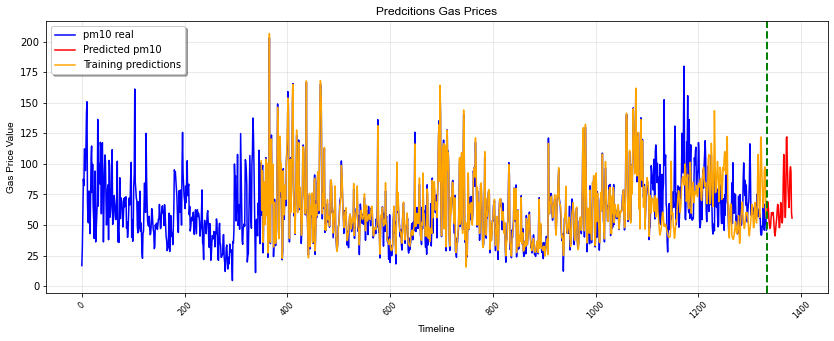

In [63]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

plt.plot(dataset_train.loc[0:].index, dataset_train.loc[0:]['PM10'], color='b', label='pm10 real')
plt.plot(range(1333,1333+50), PREDICTIONS_FUTURE['PM10'], color='r', label='Predicted pm10')
plt.plot(range(1333-984,1333), PREDICTION_TRAIN['PM10'], color='orange', label='Training predictions')

plt.axvline(x = 1333, color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions Gas Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Gas Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()